In [ ]:
Graham SMith
student ID ~ 912355584

I worked on this assignement with Edie Espejo

# Assignment 4

In this assignment, you'll combine the assignment 3 data set with nutrition data from the [USDA Food Composition Databases](https://ndb.nal.usda.gov/ndb/search/list). The CSV file `fresh.csv` contains the fresh fruits and vegetables data you extracted in assignment 3.

The USDA Food Composition Databases have a [documented](https://ndb.nal.usda.gov/ndb/doc/index) web API that returns data in JSON format . You need a key in order to use the API. Only 1000 requests are allowed per hour, so it would be a good idea to use [caching][requests_cache].

[Sign up for an API key here](https://api.data.gov/signup/). The key will work with any Data.gov API. You may need the key again later in the quarter, so make sure you save it.

These modules may be useful:

* [requests](http://docs.python-requests.org/en/master/user/quickstart/)
* [requests_cache][]
* [urlparse](https://docs.python.org/2/library/urlparse.html)
* [pandas](http://pandas.pydata.org/pandas-docs/stable/)

[requests_cache]: https://pypi.python.org/pypi/requests-cache

__Exercise 1.1.__ Read the [search request documentation](https://ndb.nal.usda.gov/ndb/doc/apilist/API-SEARCH.md), then write a function called `ndb_search()` that makes a search request. The function should accept the search term as an argument. The function should return the search result items as a list (for 0 items, return an empty list).

Note that the search url is: `https://api.nal.usda.gov/ndb/search`

As an example, a search for `"quail eggs"` should return this list:

```python
[{u'ds': u'BL',
  u'group': u'Branded Food Products Database',
  u'name': u'CHAOKOH, QUAIL EGG IN BRINE, UPC: 044738074186',
  u'ndbno': u'45094707',
  u'offset': 0},
 {u'ds': u'BL',
  u'group': u'Branded Food Products Database',
  u'name': u'L&W, QUAIL EGGS, UPC: 024072000256',
  u'ndbno': u'45094890',
  u'offset': 1},
 {u'ds': u'BL',
  u'group': u'Branded Food Products Database',
  u'name': u'BUDDHA, QUAIL EGGS IN BRINE, UPC: 761934535098',
  u'ndbno': u'45099560',
  u'offset': 2},
 {u'ds': u'BL',
  u'group': u'Branded Food Products Database',
  u'name': u'GRAN SABANA, QUAIL EGGS, UPC: 819140010103',
  u'ndbno': u'45169279',
  u'offset': 3},
 {u'ds': u'BL',
  u'group': u'Branded Food Products Database',
  u'name': u"D'ARTAGNAN, QUAIL EGGS, UPC: 736622102630",
  u'ndbno': u'45178254',
  u'offset': 4},
 {u'ds': u'SR',
  u'group': u'Dairy and Egg Products',
  u'name': u'Egg, quail, whole, fresh, raw',
  u'ndbno': u'01140',
  u'offset': 5}]
```

As usual, make sure you document and test your function.

In [343]:
#import necessary packages
from urllib2 import Request, urlopen
import pandas as pd
import json
import requests
import re
import numpy as np
from sklearn import preprocessing
from fastcache import clru_cache
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

<font size="4"><font color="darkblue">
The following function takes in search terms and concatenates it with various other fixes parameters to return a searchable API query
</font></font>

In [ ]:
#funcion to find json entry for requested item
@clru_cache(maxsize=128,typed=False,state=None) #cache the function to reduce run times on subsequent calls 
def ndb_get(q):
    
    #define fixed parameters
    url = 'https://api.nal.usda.gov/ndb/search'
    set_format = '?format=json'
    sort = '&sort=r'
    offset = '&offset=0'
    api_key = '&api_key=gmXPCpodmZGfHapRnS6p63hmYf74WkWbndMeA6ht'
    
    #define our search term
    search_terms = '&q=' + q
    
    #concatenate terms to form the search query
    query = url+set_format+search_terms+sort+offset+api_key
    
    #get response object
    request = requests.get(query)
    
    #coerce to json
    request_json = request.json()
    
    #if we get a KeyError (from NaN's) return an empty list
    try:
        search = request_json['list']['item']
    except KeyError:
        search = []
    return(search)

#function to pull the ndbno from the json data
def ndb_search(q):
    
    #run ndb_get
    search = ndb_get(q)
    
    #error correction in case of NaN's
    if len(search)==0:
        return([])
    else:
        return(search[0]['ndbno'])

__Exercise 1.2.__ Use your search function to get NDB numbers for the foods in the `fresh.csv` file. It's okay if you don't get an NDB number for every food, but try to come up with a strategy that gets most of them. Discuss your strategy in a short paragraph.

Hints:

* The foods are all raw and unbranded.
* You can test search terms with the [online search page](https://ndb.nal.usda.gov/ndb/search/list).
* You can convert the output of `ndb_search()` to a data frame with `pd.DataFrame()`.
* The string methods for [Python](https://docs.python.org/2/library/stdtypes.html#string-methods) and [Pandas](http://pandas.pydata.org/pandas-docs/stable/text.html#method-summary) are useful here. It's okay if you use _simple_ regular expressions in the Pandas methods, although this exercise can be solved without them.
* You can merge data frames that have a column in common with `pd.merge()`.

<font size="4"><font color="darkblue">
Most of the requested food from fresh.csv could be grabbed either by just running ndb_search straight up, or by removing underscores and replacing them with spaces
</font></font>

In [155]:
#make a DF from the CSV
fresh = pd.DataFrame.from_csv('fresh.csv')

#define the food column
food = fresh.iloc[:,4]

#add raw, since we know all our searches will have it
fresh.food = food + ' raw'

#redefine the index as consecutive integers so it's iterable
fresh.index = range(49)

#iterate throuh the food and replace all the underscores with spaces, as this causes most of the problems
for x in fresh.index:
    fresh.iloc[x,4] = re.sub('_',' ',fresh.iloc[x,4])

#use the ndb_retrieve function on fresh
ndbno = [ndb_search(x) for x in fresh.food]

#attach the ndbno information to the original dataframe
fresh_new = fresh.assign(ndbno=ndbno)

#as there is only one missing value left, it seemed appropriate to simply add it into the dataframe directly instead of trying to come up
#with a systematic way to pull it out
ndb_search('kiwifruit')
fresh_new.iloc[12,6] = '09148'

#the ndbno's for a couple of the results threw critical errors furthur down the line, so it seemed reasonable 
#to remove them since there were so few
fresh_new = fresh_new.drop(fresh_new.index[[32,35]])

fresh_new = 

#give it a new range now that we have 2 fewer values
fresh_new.index = range(47)
fresh_new


,price_per_lb,yield,lb_per_cup,price_per_cup,food,type,ndbno
0,0.333412,0.520000,0.330693,0.212033,watermelon raw,fruit,09326
1,0.535874,0.510000,0.374786,0.393800,cantaloupe raw,fruit,09181
2,1.377962,0.740000,0.407855,0.759471,tangerines raw,fruit,09221
3,2.358808,0.940000,0.319670,0.802171,strawberries raw,fruit,09316
4,1.827416,0.940000,0.363763,0.707176,plums raw,fruit,09279
5,1.035173,0.730000,0.407855,0.578357,oranges raw,fruit,09201
6,6.975811,0.960000,0.319670,2.322874,raspberries raw,fruit,09302
7,2.173590,0.560000,0.341717,1.326342,pomegranate raw,fruit,09286
8,0.627662,0.510000,0.363763,0.447686,pineapple raw,fruit,09266
9,3.040072,0.930000,0.363763,1.189102,apricots raw,fruit,09021


<font size="4"><font color="darkblue">
These results aren't perfect. In particular, the values for green beans and red peppers are likely incorrect since they're a different length from the others.
</font></font>

__Exercise 1.3.__ Read the [food reports V2 documentation](https://ndb.nal.usda.gov/ndb/doc/apilist/API-FOOD-REPORTV2.md), then write a function called `ndb_report()` that requests a _basic_ food report. The function should accept the NDB number as an argument and return the list of nutrients for the food.

Note that the report url is: `https://api.nal.usda.gov/ndb/V2/reports`

For example, for `"09279"` (raw plums) the first element of the returned list should be:

```python
{u'group': u'Proximates',
 u'measures': [{u'eqv': 165.0,
   u'eunit': u'g',
   u'label': u'cup, sliced',
   u'qty': 1.0,
   u'value': u'143.93'},
  {u'eqv': 66.0,
   u'eunit': u'g',
   u'label': u'fruit (2-1/8" dia)',
   u'qty': 1.0,
   u'value': u'57.57'},
  {u'eqv': 151.0,
   u'eunit': u'g',
   u'label': u'NLEA serving',
   u'qty': 1.0,
   u'value': u'131.72'}],
 u'name': u'Water',
 u'nutrient_id': u'255',
 u'unit': u'g',
 u'value': u'87.23'}
```

Be sure to document and test your function.

<font size="4"><font color="darkblue">
The following function finds ndb numbers in a nearly identical way as the ndb_search function
</font></font>

In [375]:
@clru_cache(maxsize=128,typed=False,state=None)
def ndb_report(ndbno):
    
    #set all the fixed parameters of the query
    url = 'https://api.nal.usda.gov/ndb/V2/reports'
    set_type = '&type=b'
    set_format = '&format=json'
    api_key = '&api_key=gmXPCpodmZGfHapRnS6p63hmYf74WkWbndMeA6ht'
    
    #set our parameter
    set_ndbno = '?ndbno=' + str(ndbno)
    
    #concatenate everything into a query
    query = url + set_ndbno + set_type + set_format + api_key
    
    #get request object
    request = requests.get(query)
    
    #coerce to json
    request_json = request.json()
    
    #error correction in case of NaN's
    try:
        #pull out nutrients from the json
        search = request_json['foods'][0]['food']['nutrients']
    except KeyError:
        search = []
    return(search)

In [376]:
#list comprehension to get all the nutrients for all the foods
all_nuts = [ndb_report(x) for x in fresh_new.ndbno]

__Exercise 1.4.__ Which foods provide the best combination of price, yield, and nutrition? You can use kilocalories as a measure of "nutrition" here, but more a detailed analysis is better. Use plots to support your analysis.

<font size="4"><font color="darkblue">
First we need to cut down the large list of nutrients to a few important ones, which were determained by some cursory research on google. protein, fiber, sugar, iron, sodium and vitamin C were all consistently mentioned as important nutritional components to watch out for in a healthy diet.
</font></font>

In [333]:
#get list of all the nutrient names, under the assumption that an arbitrary entry will have the same nutrient names as the average entry
all_nuts = [ndb_report(u'09326')[x]["name"] for x in range(len(ndb_report(u'09326')))]

# Create desired column names for future data frame columns
nut_names = ['kcal', 'protein', 'fiber', 'sugar', 'iron', 'sodium', 'vitamin_c']

# Identify indexes of the desired names in nut_names
ind = [1, 2, 5, 6, 8, 12, 14]

#get the nutrient values using ndb_report, which returns a list where each entry represents the column of nutrients
nuts = [[ndb_report(x)[i]["value"] for x in fresh_new.ndbno] for i in ind]

#convert all the values to numeric
nut_num = map(pd.to_numeric, nuts)

#assign the appropriate column names to our data frame
fresh_nuts = fresh_new
for i in range(len(l)):
    fresh_nuts[nut_names[i]] = nut_num[i]

fresh_nuts

,price_per_lb,yield,lb_per_cup,price_per_cup,food,type,ndbno,kcal,protein,fiber,sugar,iron,sodium,vitamin_c
0,0.333412,0.520000,0.330693,0.212033,watermelon raw,fruit,09326,30,0.61,0.4,6.20,0.24,1.00,8.100
1,0.535874,0.510000,0.374786,0.393800,cantaloupe raw,fruit,09181,34,0.84,0.9,7.86,0.21,16.00,36.700
2,1.377962,0.740000,0.407855,0.759471,tangerines raw,fruit,09221,43,0.50,0.2,9.90,0.20,1.00,31.000
3,2.358808,0.940000,0.319670,0.802171,strawberries raw,fruit,09316,32,0.67,2.0,4.89,0.41,1.00,58.800
4,1.827416,0.940000,0.363763,0.707176,plums raw,fruit,09279,46,0.70,1.4,9.92,0.17,0.00,9.500
5,1.035173,0.730000,0.407855,0.578357,oranges raw,fruit,09201,49,1.04,2.5,40.00,10.00,0.06,0.087
6,6.975811,0.960000,0.319670,2.322874,raspberries raw,fruit,09302,52,1.20,6.5,4.42,0.69,1.00,26.200
7,2.173590,0.560000,0.341717,1.326342,pomegranate raw,fruit,09286,83,1.67,4.0,13.67,0.30,3.00,10.200
8,0.627662,0.510000,0.363763,0.447686,pineapple raw,fruit,09266,50,0.54,1.4,9.85,0.29,1.00,47.800
9,3.040072,0.930000,0.363763,1.189102,apricots raw,fruit,09021,48,1.40,2.0,9.24,0.39,1.00,10.000


In [335]:
#find the standard errors for each nutrient
def find_error(nut):
    nut_mean = np.mean(nut)
    nut_error = [np.sqrt((x-nut_mean)**2) for x in nut]
    return(nut_error)

kcal_error = find_error(fresh_nuts.kcal)
protein_error = find_error(fresh_nuts.protein)
fiber_error = find_error(fresh_nuts.fiber)
sugar_error = find_error(fresh_nuts.sugar)
iron_error = find_error(fresh_nuts.iron)
sodium_error = find_error(fresh_nuts.sodium)
vitamin_c_error = find_error(fresh_nuts.vitamin_c)

<font size="4"><font color="darkblue">
Next we plot the standard errors to check for normality
</font></font>

(array([ 10.,   7.,   7.,   7.,   1.,   0.,   6.,   2.,   2.,   3.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([   0.42553191,    4.46382979,    8.50212766,   12.54042553,
          16.5787234 ,   20.61702128,   24.65531915,   28.69361702,
          32.73191489,   36.77021277,   40.80851064,   44.84680851,
          48.88510638,   52.92340426,   56.96170213,   61.        ,
          65.03829787,   69.07659574,   73.11489362,   77.15319149,
          81.19148936,   85.22978723,   89.26808511,   93.30638298,
          97.34468085,  101.38297872,  105.4212766 ,  109.45957447,
         113.49787234,  117.53617021,  121.57446809]),
 <a list of 30 Patch objects>)

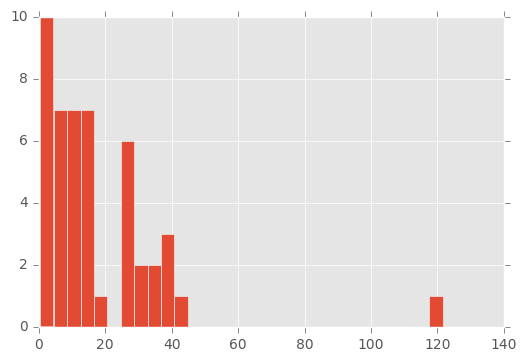

In [334]:
plt.hist(kcal_error, bins=30)

(array([ 4.,  5.,  4.,  2.,  8.,  4.,  4.,  4.,  3.,  1.,  1.,  0.,  3.,
         0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([ 0.05680851,  0.15314184,  0.24947518,  0.34580851,  0.44214184,
         0.53847518,  0.63480851,  0.73114184,  0.82747518,  0.92380851,
         1.02014184,  1.11647518,  1.21280851,  1.30914184,  1.40547518,
         1.50180851,  1.59814184,  1.69447518,  1.79080851,  1.88714184,
         1.98347518,  2.07980851,  2.17614184,  2.27247518,  2.36880851,
         2.46514184,  2.56147518,  2.65780851,  2.75414184,  2.85047518,
         2.94680851]),
 <a list of 30 Patch objects>)

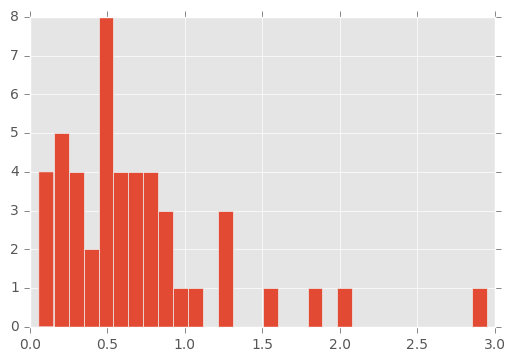

In [329]:
plt.hist(protein_error, bins=30)

(array([ 4.,  5.,  4.,  2.,  8.,  4.,  4.,  4.,  3.,  1.,  1.,  0.,  3.,
         0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([ 0.05680851,  0.15314184,  0.24947518,  0.34580851,  0.44214184,
         0.53847518,  0.63480851,  0.73114184,  0.82747518,  0.92380851,
         1.02014184,  1.11647518,  1.21280851,  1.30914184,  1.40547518,
         1.50180851,  1.59814184,  1.69447518,  1.79080851,  1.88714184,
         1.98347518,  2.07980851,  2.17614184,  2.27247518,  2.36880851,
         2.46514184,  2.56147518,  2.65780851,  2.75414184,  2.85047518,
         2.94680851]),
 <a list of 30 Patch objects>)

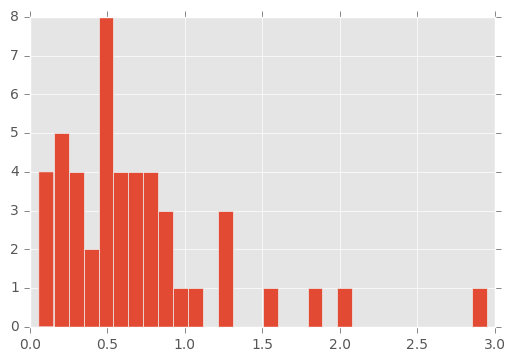

In [319]:
plt.hist(protein_error, bins=30)

(array([  9.,   7.,   4.,  11.,   5.,   1.,   3.,   1.,   2.,   0.,   0.,
          0.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  6.38297872e-03,   3.15957447e-01,   6.25531915e-01,
          9.35106383e-01,   1.24468085e+00,   1.55425532e+00,
          1.86382979e+00,   2.17340426e+00,   2.48297872e+00,
          2.79255319e+00,   3.10212766e+00,   3.41170213e+00,
          3.72127660e+00,   4.03085106e+00,   4.34042553e+00,
          4.65000000e+00,   4.95957447e+00,   5.26914894e+00,
          5.57872340e+00,   5.88829787e+00,   6.19787234e+00,
          6.50744681e+00,   6.81702128e+00,   7.12659574e+00,
          7.43617021e+00,   7.74574468e+00,   8.05531915e+00,
          8.36489362e+00,   8.67446809e+00,   8.98404255e+00,
          9.29361702e+00]),
 <a list of 30 Patch objects>)

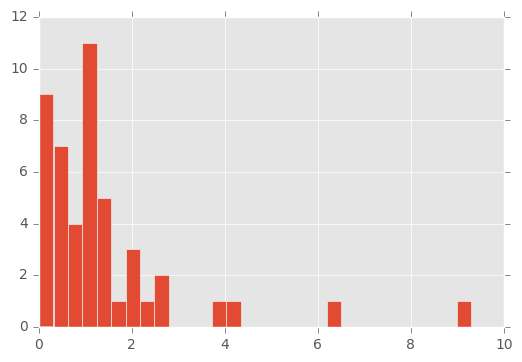

In [320]:
plt.hist(fiber_error,bins=30)

(array([ 13.,   5.,   5.,  10.,   8.,   0.,   0.,   0.,   1.,   1.,   0.,
          1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([  0.68744681,   2.86195035,   5.0364539 ,   7.21095745,
          9.38546099,  11.55996454,  13.73446809,  15.90897163,
         18.08347518,  20.25797872,  22.43248227,  24.60698582,
         26.78148936,  28.95599291,  31.13049645,  33.305     ,
         35.47950355,  37.65400709,  39.82851064,  42.00301418,
         44.17751773,  46.35202128,  48.52652482,  50.70102837,
         52.87553191,  55.05003546,  57.22453901,  59.39904255,
         61.5735461 ,  63.74804965,  65.92255319]),
 <a list of 30 Patch objects>)

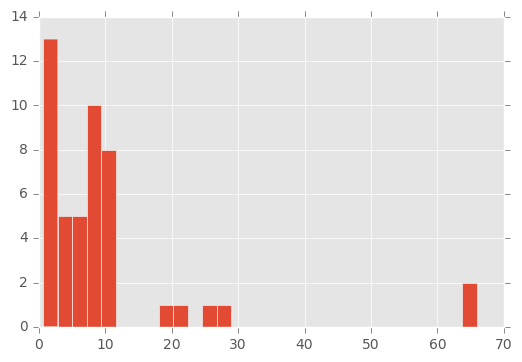

In [321]:
plt.hist(sugar_error, bins=30)

(array([  6.,  36.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([  2.28425532,   4.38530496,   6.48635461,   8.58740426,
         10.6884539 ,  12.78950355,  14.89055319,  16.99160284,
         19.09265248,  21.19370213,  23.29475177,  25.39580142,
         27.49685106,  29.59790071,  31.69895035,  33.8       ,
         35.90104965,  38.00209929,  40.10314894,  42.20419858,
         44.30524823,  46.40629787,  48.50734752,  50.60839716,
         52.70944681,  54.81049645,  56.9115461 ,  59.01259574,
         61.11364539,  63.21469504,  65.31574468]),
 <a list of 30 Patch objects>)

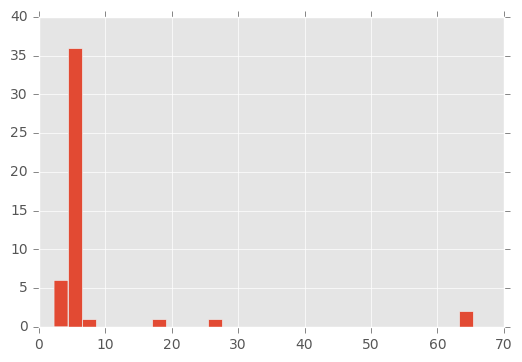

In [322]:
plt.hist(iron_error, bins=30)

(array([  3.,   2.,   3.,   6.,  15.,  10.,   1.,   1.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   2.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  0.07106383,   1.63299291,   3.19492199,   4.75685106,
          6.31878014,   7.88070922,   9.4426383 ,  11.00456738,
         12.56649645,  14.12842553,  15.69035461,  17.25228369,
         18.81421277,  20.37614184,  21.93807092,  23.5       ,
         25.06192908,  26.62385816,  28.18578723,  29.74771631,
         31.30964539,  32.87157447,  34.43350355,  35.99543262,
         37.5573617 ,  39.11929078,  40.68121986,  42.24314894,
         43.80507801,  45.36700709,  46.92893617]),
 <a list of 30 Patch objects>)

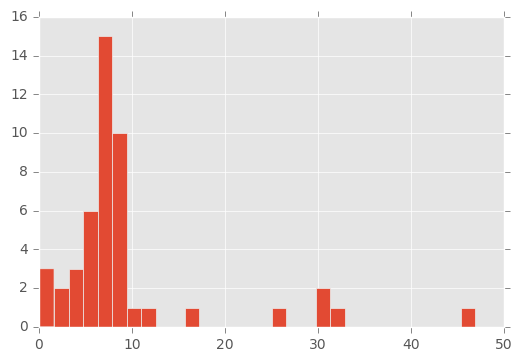

In [328]:
plt.hist(sodium_error, bins=30)

(array([ 4.,  2.,  2.,  5.,  8.,  8.,  9.,  1.,  0.,  0.,  0.,  3.,  0.,
         0.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([  0.50365957,   3.73699291,   6.97032624,  10.20365957,
         13.43699291,  16.67032624,  19.90365957,  23.13699291,
         26.37032624,  29.60365957,  32.83699291,  36.07032624,
         39.30365957,  42.53699291,  45.77032624,  49.00365957,
         52.23699291,  55.47032624,  58.70365957,  61.93699291,
         65.17032624,  68.40365957,  71.63699291,  74.87032624,
         78.10365957,  81.33699291,  84.57032624,  87.80365957,
         91.03699291,  94.27032624,  97.50365957]),
 <a list of 30 Patch objects>)

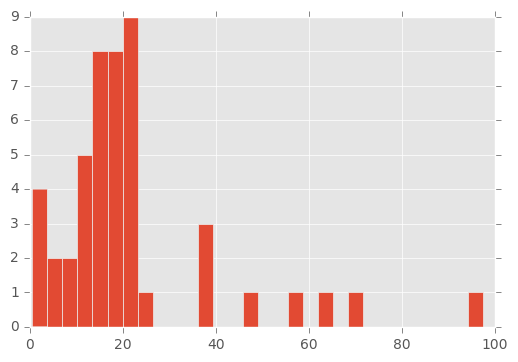

In [327]:
plt.hist(vitamin_c_error, bins=30)

<font size="4"><font color="darkblue">
As you can see, most of the plots are skewed to the left which indicates that the standard errors are not normally distributed. Given this fact, in an ideal world I would use bootstrapping or some other method to build a model. Or even better - build an algorithm that was trained on foods we knew to be unhealthy to try and identify what nutrients contribute to positive health outcomes.
</font></font>

<font size="4"><font color="darkblue">
However, this is not an ideal world and I don't know how to do any of those things so for the purpose of this assignment I will assume the numeric variables are normally distributed.

I am defining the best combination of price, yield, and nutrition by a ranking system created by adding together the standard Z-scores from the variables of interest, then subtracting the Z-scores for the variables that I think will have a negative impact on overall nutrition.
</font></font>

In [380]:
standardized = fresh_nuts[["food", "price_per_lb", "yield", "kcal","protein", "fiber", "sugar", "iron", "sodium", "vitamin_c"]]

In [392]:
variable_names = list(standardized.iloc[:,-9:].columns)

for variable in variable_names:
    new_col_name = variable+"_stdz"
    standardized[new_col_name] = (standardized[variable] - standardized[variable].mean()) / standardized[variable].std(ddof=0)

#variables that are likely to be unhealthy
standardized["price_per_lb_stdz"] = -1*(standardized["price_per_lb_stdz"])
standardized["kcal_stdz"] = -1*(standardized["kcal_stdz"])
standardized["sugar_stdz"] = -1*(standardized["sugar_stdz"])
standardized['sodium_stdz'] = -1*(standardized['sodium_stdz'])

<font size="4"><font color="darkblue">
Now we to compute the health score for each food, and look at the ones that have the highest score
</font></font>

In [393]:
# sum up the stdz columns
standardized["health_score"] = standardized.iloc[:,-8:].sum(axis=1)

#sort by hightest values
standardized.sort_values(by="health_score", ascending=False)[0:15]

,food,price_per_lb,yield,kcal,protein,fiber,sugar,iron,sodium,vitamin_c,...,health_score,kcal_stdz_stdz_stdz,protein_stdz_stdz_stdz,fiber_stdz_stdz_stdz,sugar_stdz_stdz_stdz,iron_stdz_stdz_stdz,sodium_stdz_stdz_stdz,vitamin_c_stdz_stdz_stdz,totals_stdz,health_score_stdz
41,kale raw,2.807302,1.050000,49,4.28,3.6,2.26,1.47,38.00,120.000,...,14.341215,0.135516,3.341766,0.414901,-0.531096,-0.279210,2.311347,3.406832,2.854097,2.822577
35,cabbage raw,1.056450,0.779107,19,2.60,2.1,77.00,71.00,0.18,0.030,...,12.392538,-1.001849,1.436597,-0.281540,3.970672,4.327403,-0.609410,-0.784986,2.164099,2.169704
34,cabbage raw,0.579208,0.778797,19,2.60,2.1,77.00,71.00,0.18,0.030,...,12.392225,-1.001849,1.436597,-0.281540,3.970672,4.327403,-0.609410,-0.784986,2.163920,2.169569
45,brussels sprouts raw,2.763553,1.060000,43,3.38,3.8,2.20,1.40,25.00,85.000,...,9.109202,-0.091957,2.321140,0.507759,-0.534710,-0.283847,1.307385,2.183913,1.821806,1.785756
19,grapefruit raw,0.897802,0.490000,37,0.88,12.0,0.08,12.00,33.30,0.020,...,7.132696,-0.319430,-0.513932,4.314967,-0.662402,0.418441,1.948376,-0.785336,1.184042,1.228540
30,mustard greens raw,2.569235,0.840000,27,2.86,3.2,1.32,1.64,20.00,70.000,...,5.585713,-0.698552,1.731445,0.229183,-0.587714,-0.267946,0.921246,1.659804,0.953258,0.946437
36,sweet potatoes raw,0.918897,0.811301,86,1.57,3.0,4.18,0.61,55.00,2.400,...,5.136554,1.538265,0.268548,0.136325,-0.415450,-0.336188,3.624220,-0.702177,1.281483,1.279794
29,turnip greens raw,2.471749,0.750000,32,1.50,3.2,0.81,1.10,40.00,60.000,...,4.943701,-0.508991,0.189166,0.229183,-0.618433,-0.303723,2.465803,1.310399,0.832734,0.838572
40,avocados raw,2.235874,0.740753,167,1.96,6.8,0.30,0.61,8.00,8.800,...,4.636381,4.609150,0.710819,1.900640,-0.649151,-0.336188,-0.005488,-0.478558,1.742207,1.752100
31,potatoes raw,0.564320,0.811301,58,2.57,2.5,30.00,23.00,0.35,0.021,...,3.899722,0.476725,1.402577,-0.095822,1.139750,1.147230,-0.596281,-0.785301,0.845280,0.842289


<font size="4"><font color="darkblue">
Checking the distribution of the health scores, we can see that the data is roughly normal, and for the sake of future analyses normality can be assumed.
</font></font>

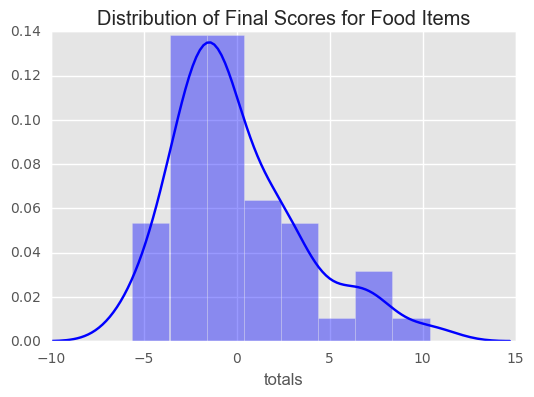

In [394]:
health_scores = standardized["health_score"]
sns.distplot(x, color="blue")
plt.title("Distribution of Health Scores")
sns.plt.show()